In [3]:
import os
import re
import six
import PIL
import lmdb
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display

from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model

# 주요 함수 선언

### 검출할 문자의 인코딩 사전 구성

In [4]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS

### lmdb 데이터를 import, 훈련용 데이터 셋 객체로 구성

In [5]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = PIL.Image.open(buf).convert('RGB')

            except IOError:
                img = PIL.Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

### 인코딩 라벨 객체 구성 (중복문에는 -를 넣도록 구성)

In [6]:
class LabelConverter(object):
    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i
    
    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)
    
    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

### ctc 알고리즘 구축

In [8]:
def ctc_lambda_func(args):
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

### 모델 구축 함수 선언

In [7]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = tf.keras.layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = tf.keras.layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = tf.keras.layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = tf.keras.layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = tf.keras.layers.Dense(64, activation='relu')(sequnce)
    sequnce = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = tf.keras.layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = tf.keras.layers.Input(shape=[22], dtype='int64', name='label')
    input_length = tf.keras.layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = tf.keras.layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = tf.keras.layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = tf.keras.Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

### 학습된 모델 시험을 위한 함수 선언

In [67]:
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    chars += ' '
    results = []
    indexes = tf.keras.backend.get_value(
        tf.keras.backend.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

In [76]:
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][70:71,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(PIL.Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

# 모델 학습

In [20]:
BATCH_SIZE = 128
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
label_converter = LabelConverter(TARGET_CHARACTERS)

HOME_DIR = os.getenv('HOME')+'/aiffel/node_data/GD04/ocr'

### 학습 및 검증용 데이터 셋 import

In [21]:
TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'

In [22]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

### 모델 구축 및 컴파일

In [23]:
model = build_crnn_model()

optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

### 모델 학습 및 저장

In [24]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(os.getenv('HOME')+"/aiffel/model_weight/GD04/ocr_eng.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

history_eng = model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[checkpoint]
)

Epoch 1/20
565/565 [==============================] - 95s 146ms/step - loss: 25.5923 - val_loss: 24.9351

Epoch 00001: val_loss improved from inf to 24.93514, saving model to /aiffel/aiffel/model_weight/GD04/ocr_eng.keras
Epoch 2/20
565/565 [==============================] - 82s 145ms/step - loss: 14.9434 - val_loss: 9.7934

Epoch 00002: val_loss improved from 24.93514 to 9.79344, saving model to /aiffel/aiffel/model_weight/GD04/ocr_eng.keras
Epoch 3/20
565/565 [==============================] - 81s 144ms/step - loss: 7.1132 - val_loss: 6.8508

Epoch 00003: val_loss improved from 9.79344 to 6.85081, saving model to /aiffel/aiffel/model_weight/GD04/ocr_eng.keras
Epoch 4/20
565/565 [==============================] - 81s 143ms/step - loss: 5.1209 - val_loss: 5.1989

Epoch 00004: val_loss improved from 6.85081 to 5.19886, saving model to /aiffel/aiffel/model_weight/GD04/ocr_eng.keras
Epoch 5/20
565/565 [==============================] - 81s 143ms/step - loss: 4.0599 - val_loss: 4.6384

Epo

In [25]:
model.save_weights(os.getenv('HOME')+'/aiffel/model_weight/GD04/ocr_eng_weight.keras')

In [28]:
with open('history/history_eng.json', 'w') as f:
    pd.DataFrame(history_eng.history).to_json(f)

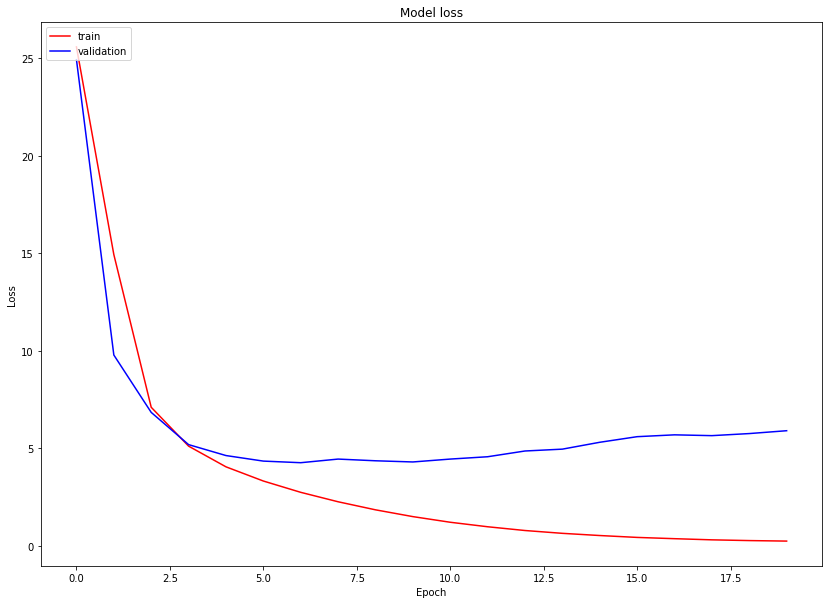

In [33]:
plt.figure(figsize=(14, 10))

plt.plot(history_eng.history['loss'], 'r')
plt.plot(history_eng.history['val_loss'], 'b')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### 모델 시연

- 모델을 불러올 경우

In [20]:
HOME_DIR = os.getenv('HOME')+'/aiffel/node_data/GD04/ocr'
checkpoint_path = os.getenv('HOME') + '/aiffel/model_weight/GD04/ocr_eng_weight.keras'

BATCH_SIZE = 128
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
label_converter = LabelConverter(TARGET_CHARACTERS)

model = build_crnn_model()
model.load_weights(checkpoint_path)

- 시연 모델을 위한 모델 생성

In [21]:
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = tf.keras.Model(inputs=input_data, outputs=y_pred)

In [22]:
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

Result: 	 RUTHENIUM               


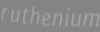

Result: 	 CLOSSES                


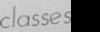

Result: 	 IFECTIOUS               


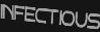

Result: 	 PALISHA                 


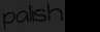

Result: 	 EALENDRAIN             


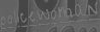

Result: 	 DULY                    


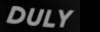

Result: 	 PEPS                    


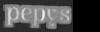

Result: 	 CALIFORNIANS            


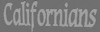

Result: 	 IRECRUDESCED            


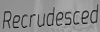

Result: 	 CHASTISER               


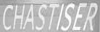

Result: 	 IMOMLIRING              


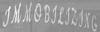

Result: 	 ROSILY                  


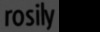

Result: 	 RADAR                   


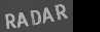

Result: 	 MUFFED                 


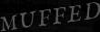

Result: 	 MONIMENTEL              


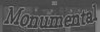

Result: 	 JOS                     


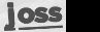

Result: 	 REMOLDS                 


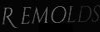

Result: 	 INDUBITABLE             


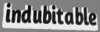

Result: 	 RETRESPECTED            


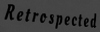

Result: 	 STOCKHAUSEN             


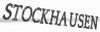

Result: 	 WHOOSHED               


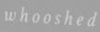

Result: 	 UNDALINING              


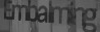

Result: 	 DAYDREAMINS             


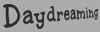

Result: 	 SIZZLES                


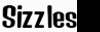

Result: 	 LABIUM                  


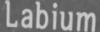

Result: 	 CIMABUE                 


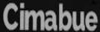

Result: 	 CORINE                  


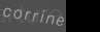

Result: 	 UNDERSIGNS              


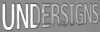

Result: 	 WEARER                  


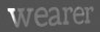

Result: 	 FOUNT                   


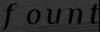

Result: 	 PERUSE                  


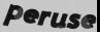

Result: 	 MCANIE                  


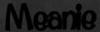

Result: 	 BOUNTIES                


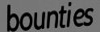

Result: 	 CORKED                  


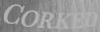

Result: 	 PICKETER                


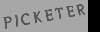

Result: 	 THREISHAES              


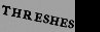

Result: 	 CAVERN                 


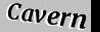

Result: 	 JUDGMENTS               


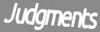

Result: 	 GALOORS                


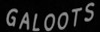

Result: 	 HUSHERS                 


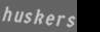

Result: 	 IMISSOURI              


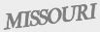

Result: 	 COASTQUARDS             


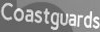

Result: 	 WINGED                  


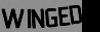

Result: 	 GSOL                    


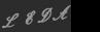

Result: 	 HANSEN                  


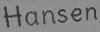

Result: 	 UPRICHTLY               


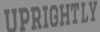

Result: 	 QUAKING                 


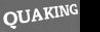

Result: 	 POLITICIED              


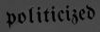

Result: 	 SLAP                    


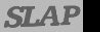

Result: 	 IEL                     


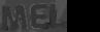

In [77]:
check_inference(model_pred, test_set, index=50)

### 마지막에 99999가 붙는 이유
- ctc 알고리즘에서 아무 것도 없는 공백의 경우 -1 인덱스의 확률로 반환하는 것 같음
- 추가로 중복문에 붙는 -의 경우 0 인덱스로 반환함 (TARGET_CHARACTERS의 앞에 -를 붙어 리스트로 만든것 같음)

In [34]:
inputs_for_just_test, outputs_for_just_test = test_set[1]
img_for_just_test = test_set[1][0]['input_image'][0:1,:,:,:]

In [35]:
img_for_just_test.shape

(1, 100, 32, 3)

In [36]:
output_for_just_test = model_pred.predict(img_for_just_test)

In [40]:
output_for_just_test.shape

(1, 24, 38)

In [39]:
result_for_just_test = decode_predict_ctc(output_for_just_test, chars="-"+TARGET_CHARACTERS)[0].replace('-','')

In [47]:
np.ones(output_for_just_test.shape[0])*output_for_just_test.shape[1]

array([24.])

In [42]:
result_1_for_just_test = tf.keras.backend.ctc_decode(
            output_for_just_test, input_length=np.ones(output_for_just_test.shape[0]) * output_for_just_test.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )

In [52]:
result_1_for_just_test[0][0]

<tf.Tensor: shape=(1, 24), dtype=int64, numpy=
array([[ 1, 12,  5, 16,  0, 16, 15, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1]])>

In [53]:
indexes_for_just_test = tf.keras.backend.get_value(result_1_for_just_test[0][0])

In [55]:
indexes_for_just_test[0]

array([ 1, 12,  5, 16,  0, 16, 15, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1])

In [56]:
TARGET_CHARACTERS

'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

In [41]:
result_for_just_test

'ALEPPO99999999999999999'

# 회고
## 결과분석
- 결과 일람
    - 학습 곡선
    <img src="images/p2.png"/>
    - 추론 결과
    <img src="images/p3.png"/>
    - 루브릭 추론 결과
    <img src="images/p4.png"/>
- 조원들과 함께 결과를 분석
    <img src="images/p5.png"/>
    - 위 사진과 같이, OCR 모델에 대하여, 소문자 부재, 디자인체 문자, 흐린 문자, 기운 문자로 정의하였음
        
## 추가실험
- 다른 언어 데이터를 이용(중국어)
    - 중국어를 선정한 이유
        - 영어 36개 문자에 비하여 중국어의 경우 약 12109개의 문자가 있음
        <img src="images/p1.png"/>
        - 영어에 비하여 유사한 문자가 다수 포함되어 있음
        - 영어에 비하여 한 문자열당 길이가 길것으로 예상
        - 실제 데이터는 그렇지 못함. 대략 2~4 문자 내외의 짧은 단어가 주였음
        - 긴 문장을 데이터로 활용하고자 한다면, 직접 만들어야 할 것으로 파악됨
    - 예상효과
        - 영어에 비하여 낮은 학습 지표를 도출할 것으로 예상 (문자수가 많기 때문)
        - 레이어 층이 깊지 않다면, 혼동문자로 인하여 추론 정확도가 폭락할 것으로 예상
        - 많은 문자수와 복잡한 형상으로 필기체나 디자인체 등에 매우 취약할 것으로 예상
        - LSTM layer 수를 늘리지 않으면 정확히 식별할 수 없을 것으로 예상
            - 이 경우 LSTM layer 수를 늘리면 약간의 정확도는 확보될지언정 결과적으로 장기의존성 문제가 발생할 수 있음
            - 현재 데이터의 길이가 매우 짧아 확인하기 어려울 것으로 판단됨
    - 실험결과
        - 학습 곡선
            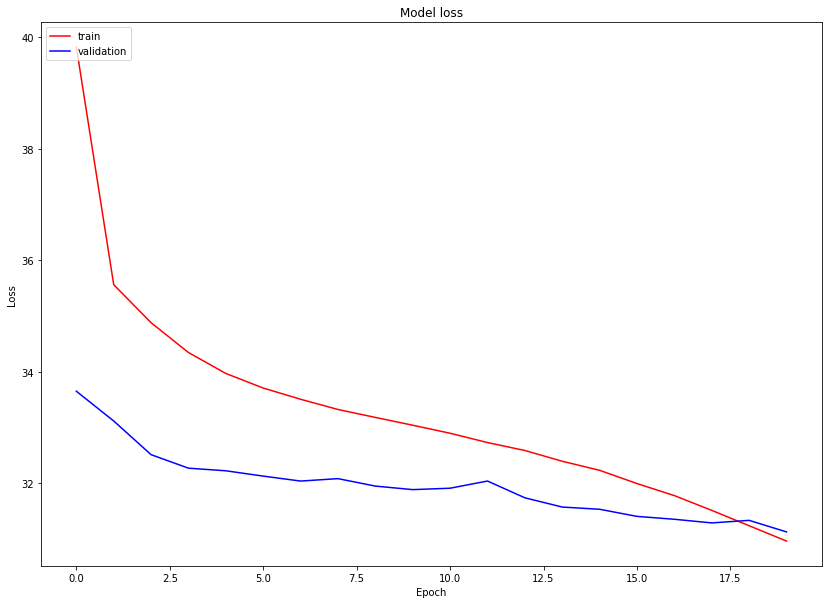
        - 추론 결과
            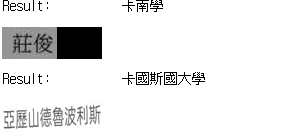
        - 예상외로 너무 학습이 진행되지 않는 문제가 있으며, 낮은 학습만큼 추론도 제대로 되지 않았음
        - 20만개의 데이터임에도 불구하고, 예측을 해야하는 class가 12,109개임으로 class 대비 데이터가 적은것으로 생각됨
        - 또한 validation loss가 초반부터 train loss에 비하여 매우 적게 나왔는데, 이는 validation set의 정답 class가 약 3000개 내외임으로 표본이 편향되어 그런 것으로 예상됨